In [1]:
import numpy as np
import pandas as pd
import datetime

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')  # 加载'ggplot'风格
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

import sqlite3
import csv

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf # 回归
from linearmodels.panel import PanelOLS # 面板回归
from statsmodels.tsa.stattools import grangercausalitytests


from joblib import Parallel,delayed
from tqdm import tqdm,tnrange,tqdm_notebook   
import warnings
warnings.filterwarnings("ignore")

# 1 可视化
## 1.1 港股通50etf（513550.SH）

In [2]:
unit_df = pd.read_excel('./qdii/513550.xlsx', header=3)
unit_df['unit_pct_change'] = unit_df['unit_floortrading'].pct_change()
unit_df['unit_pct_change_lag1'] = unit_df['unit_pct_change'].shift()
unit_df = unit_df[unit_df['unit_floortradingchange']!=unit_df['unit_floortrading']]

bar_df = pd.read_excel('./qdii/513550bar.xlsx').iloc[:-2]
bar_df['Date'] = bar_df['日期'].map(lambda x: datetime.datetime(x.year, x.month, x.day))
bar_df.rename(columns={'代码':'code', '名称':'name', '日期':'Timestamp', 
           '开盘价(元)':'open', '最高价(元)':'high', '最低价(元)':'low', '收盘价(元)':'close'}, inplace = True) 

In [3]:
# 流通份额变动百分比 最大的前10
unit_df.sort_values(by=['unit_pct_change'],ascending=False).head(10)

,Date,unit_total,unit_floortrading,unit_floortradingchange,unit_pct_change,unit_pct_change_lag1
3,2021-01-19,4660992000,4660992000,2930000000,1.692671,0.281275
4,2021-01-20,6168992000,6168992000,1508000000,0.323536,1.692671
2,2021-01-18,1730992000,1730992000,380000000,0.281275,0.110108
1,2021-01-15,1350992000,1350992000,134000000,0.110108,NaN
537,2023-04-04,3186992000,3186992000,184000000,0.061272,0.003676
9,2021-01-27,6848992000,6848992000,356000000,0.054828,0.046414
327,2022-05-26,4478992000,4478992000,221000000,0.051902,0.012604
8,2021-01-26,6492992000,6492992000,288000000,0.046414,0.002585
526,2023-03-20,3091992000,3091992000,124000000,0.041779,-0.006693
307,2022-04-25,4074992000,4074992000,150000000,0.038217,0.000000


In [4]:
# 对应的下一天
unit_df.sort_values(by=['unit_pct_change_lag1'],ascending=False).head(10)

,Date,unit_total,unit_floortrading,unit_floortradingchange,unit_pct_change,unit_pct_change_lag1
4,2021-01-20,6168992000,6168992000,1508000000,0.323536,1.692671
5,2021-01-21,6170992000,6170992000,2000000,0.000324,0.323536
3,2021-01-19,4660992000,4660992000,2930000000,1.692671,0.281275
2,2021-01-18,1730992000,1730992000,380000000,0.281275,0.110108
538,2023-04-06,3188992000,3188992000,2000000,0.000628,0.061272
10,2021-01-28,7030992000,7030992000,182000000,0.026573,0.054828
328,2022-05-27,4510992000,4510992000,32000000,0.007144,0.051902
9,2021-01-27,6848992000,6848992000,356000000,0.054828,0.046414
527,2023-03-21,3091992000,3091992000,0,0.000000,0.041779
308,2022-04-26,3975992000,3975992000,-99000000,-0.024295,0.038217


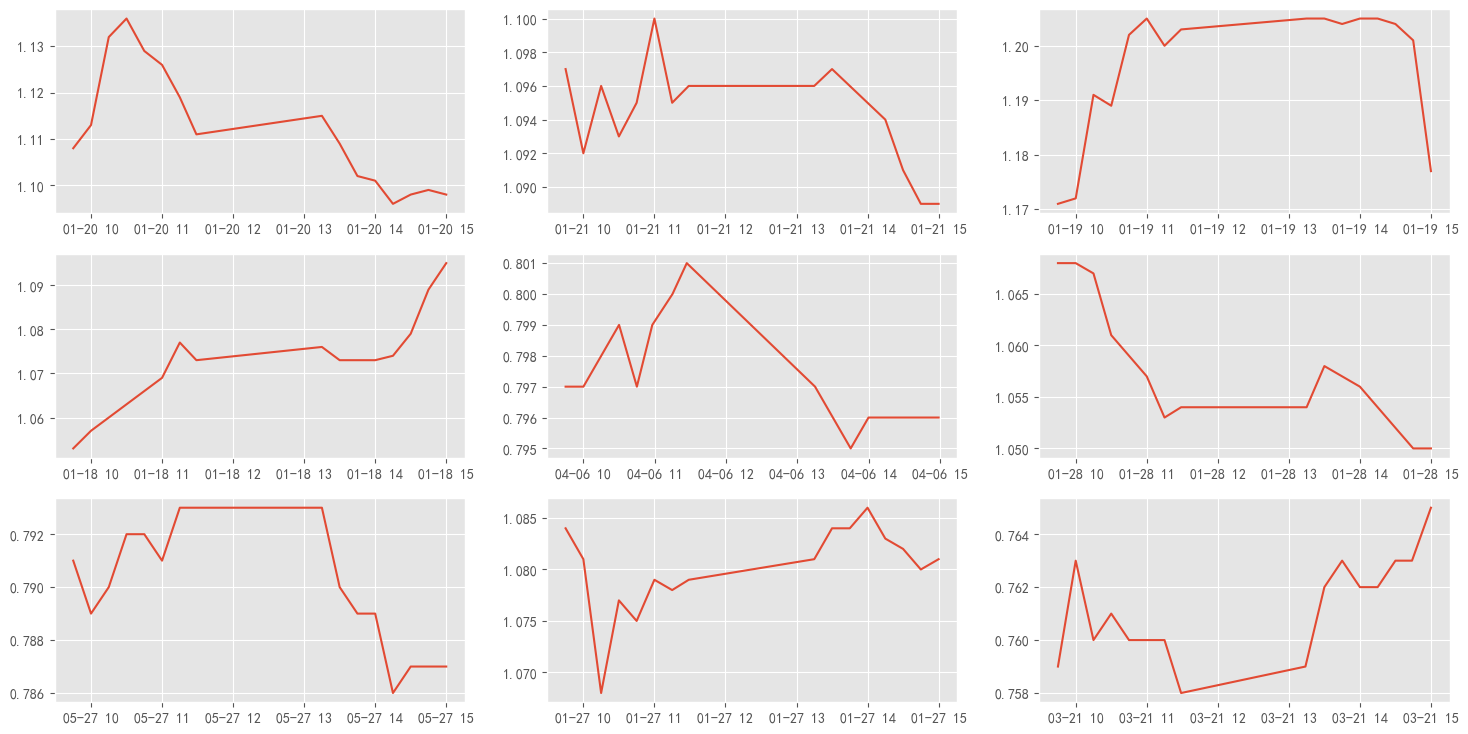

In [5]:
unit_pct_change_head10 = unit_df.sort_values(by=['unit_pct_change_lag1'],ascending=False)['Date'].iloc[:9]
fig, ax = plt.subplots(3, 3, figsize=(18, 9))

i=0
for date in unit_pct_change_head10:
    bar_df_temp = bar_df[bar_df['Date'] == date].set_index('Timestamp')
    
    i += 1
    plt.subplot(int(str(33)+str(i)))
    plt.plot(bar_df_temp.index, bar_df_temp['close'])

## 1.2 恒生科技etf HSTECH(513260.sh)

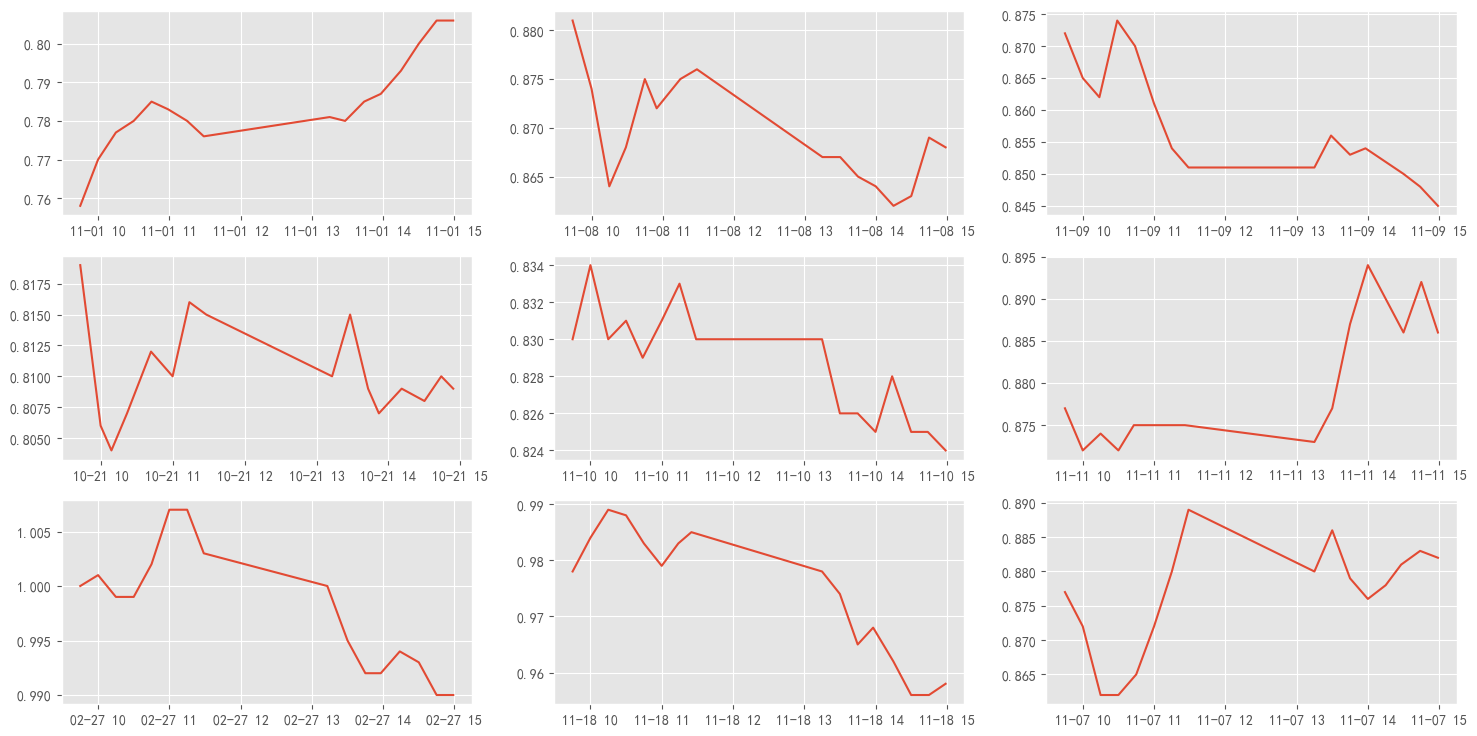

In [6]:
code = 513260

unit_df = pd.read_excel('./qdii/{}.xlsx'.format(code), header=3)
unit_df['unit_pct_change'] = unit_df['unit_floortrading'].pct_change()
unit_df['unit_pct_change_lag1'] = unit_df['unit_pct_change'].shift()
unit_df = unit_df[unit_df['unit_floortradingchange']!=unit_df['unit_floortrading']]

bar_df = pd.read_excel('./qdii/{}bar.xlsx'.format(code)).iloc[:-2]
bar_df['Date'] = bar_df['日期'].map(lambda x: datetime.datetime(x.year, x.month, x.day))
bar_df.rename(columns={'代码':'code', '名称':'name', '日期':'Timestamp', 
           '开盘价(元)':'open', '最高价(元)':'high', '最低价(元)':'low', '收盘价(元)':'close'}, inplace = True) 

unit_pct_change_head10 = unit_df.sort_values(by=['unit_pct_change_lag1'],ascending=False)['Date'].iloc[:9]
fig, ax = plt.subplots(3, 3, figsize=(18, 9))

i=0
for date in unit_pct_change_head10:
    bar_df_temp = bar_df[bar_df['Date'] == date].set_index('Timestamp')
    
    i += 1
    plt.subplot(int(str(33)+str(i)))
    plt.plot(bar_df_temp.index, bar_df_temp['close'])

## 1.3 恒生互联网etf 513330.sh

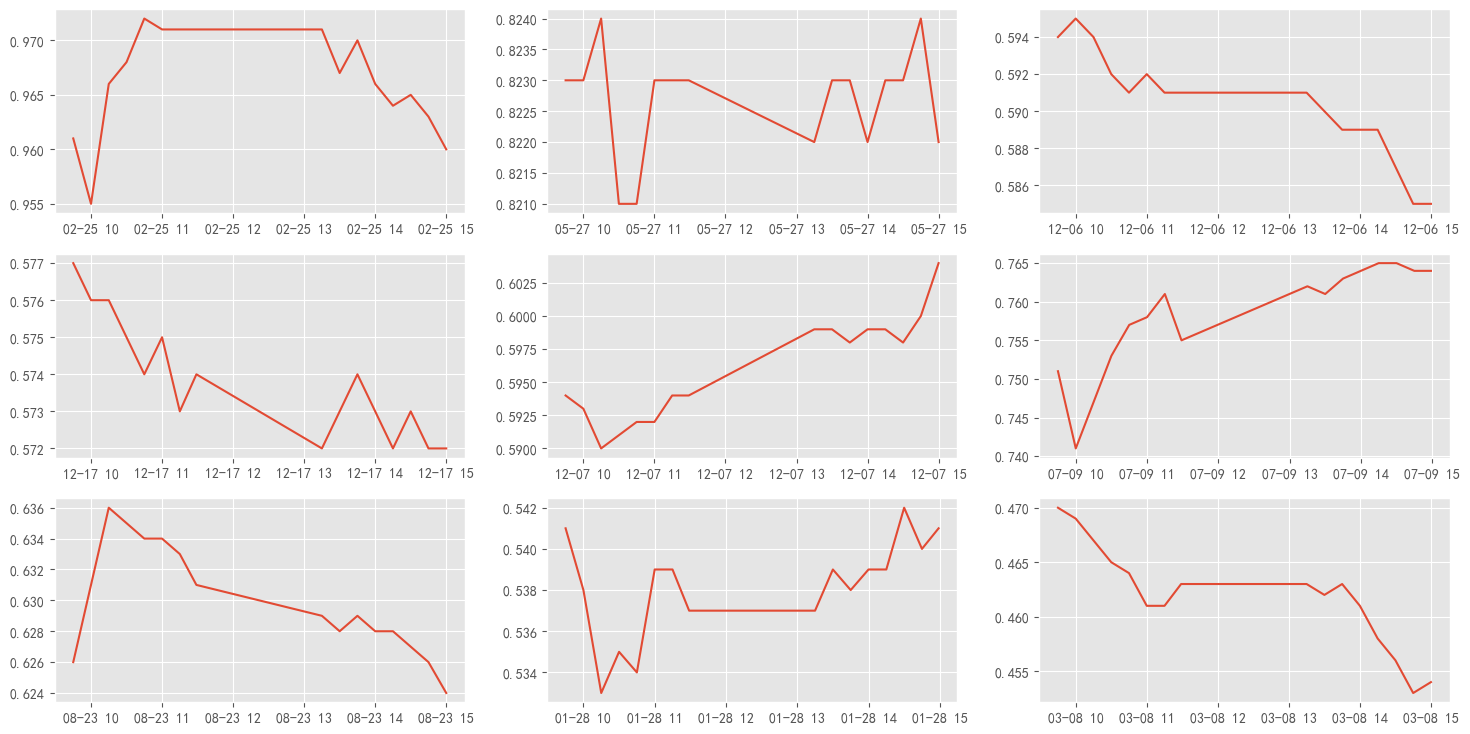

In [7]:
code = 513330

unit_df = pd.read_excel('./qdii/{}.xlsx'.format(code), header=3)
unit_df['unit_pct_change'] = unit_df['unit_floortrading'].pct_change()
unit_df['unit_pct_change_lag1'] = unit_df['unit_pct_change'].shift()
unit_df = unit_df[unit_df['unit_floortradingchange']!=unit_df['unit_floortrading']]

bar_df = pd.read_excel('./qdii/{}bar.xlsx'.format(code)).iloc[:-2]
bar_df['Date'] = bar_df['日期'].map(lambda x: datetime.datetime(x.year, x.month, x.day))
bar_df.rename(columns={'代码':'code', '名称':'name', '日期':'Timestamp', 
           '开盘价(元)':'open', '最高价(元)':'high', '最低价(元)':'low', '收盘价(元)':'close'}, inplace = True) 

unit_pct_change_head10 = unit_df.sort_values(by=['unit_pct_change_lag1'],ascending=False)['Date'].iloc[:9]
fig, ax = plt.subplots(3, 3, figsize=(18, 9))

i=0
for date in unit_pct_change_head10:
    bar_df_temp = bar_df[bar_df['Date'] == date].set_index('Timestamp')
    
    i += 1
    plt.subplot(int(str(33)+str(i)))
    plt.plot(bar_df_temp.index, bar_df_temp['close'])

## 1.4 恒生科技指数etf 513180.sh

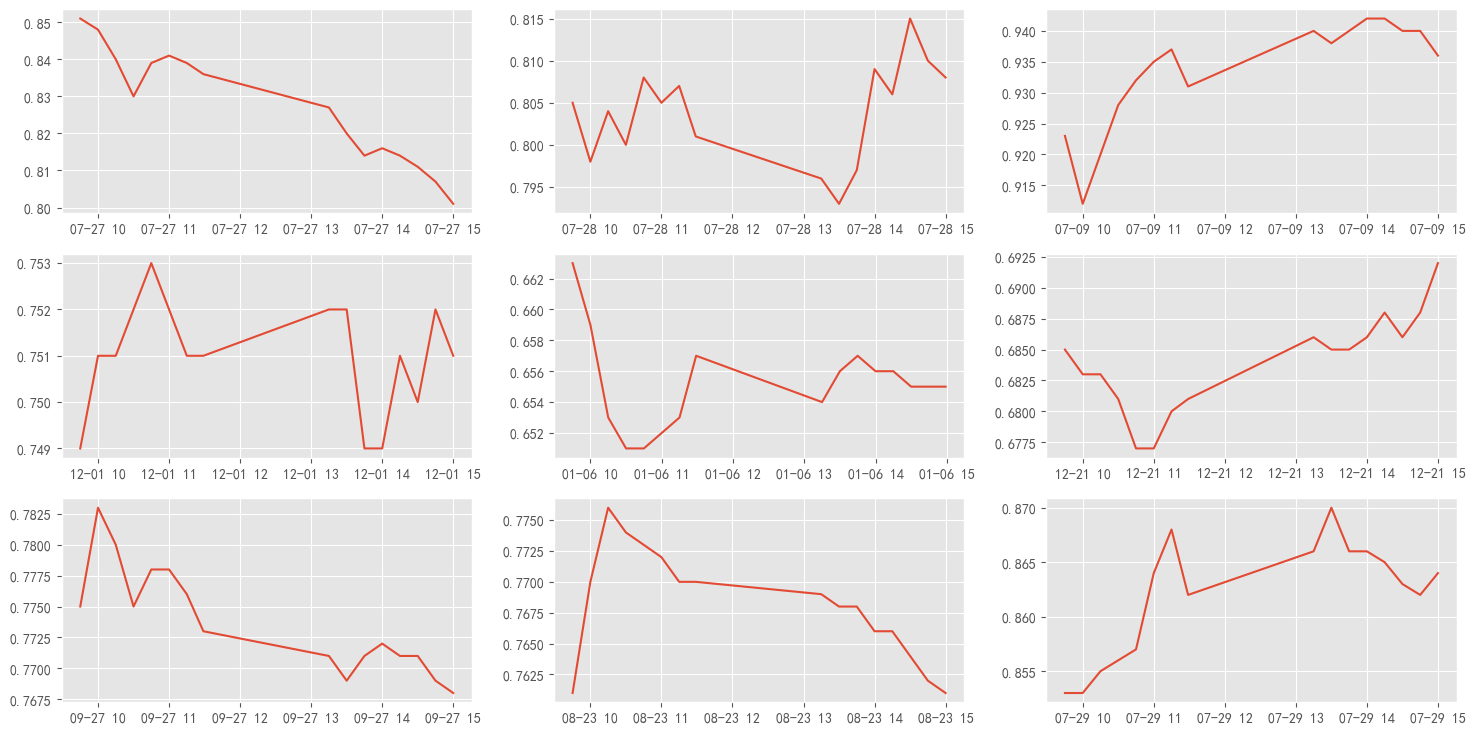

In [8]:
code = 513180

unit_df = pd.read_excel('./qdii/{}.xlsx'.format(code), header=3)
unit_df['unit_pct_change'] = unit_df['unit_floortrading'].pct_change()
unit_df['unit_pct_change_lag1'] = unit_df['unit_pct_change'].shift()
unit_df = unit_df[unit_df['unit_floortradingchange']!=unit_df['unit_floortrading']]

bar_df = pd.read_excel('./qdii/{}bar.xlsx'.format(code)).iloc[:-2]
bar_df['Date'] = bar_df['日期'].map(lambda x: datetime.datetime(x.year, x.month, x.day))
bar_df.rename(columns={'代码':'code', '名称':'name', '日期':'Timestamp', 
           '开盘价(元)':'open', '最高价(元)':'high', '最低价(元)':'low', '收盘价(元)':'close'}, inplace = True) 

unit_pct_change_head10 = unit_df.sort_values(by=['unit_pct_change_lag1'],ascending=False)['Date'].iloc[:9]
fig, ax = plt.subplots(3, 3, figsize=(18, 9))

i=0
for date in unit_pct_change_head10:
    bar_df_temp = bar_df[bar_df['Date'] == date].set_index('Timestamp')
    
    i += 1
    plt.subplot(int(str(33)+str(i)))
    plt.plot(bar_df_temp.index, bar_df_temp['close'])

## 1.5 恒生etf 159920.sz

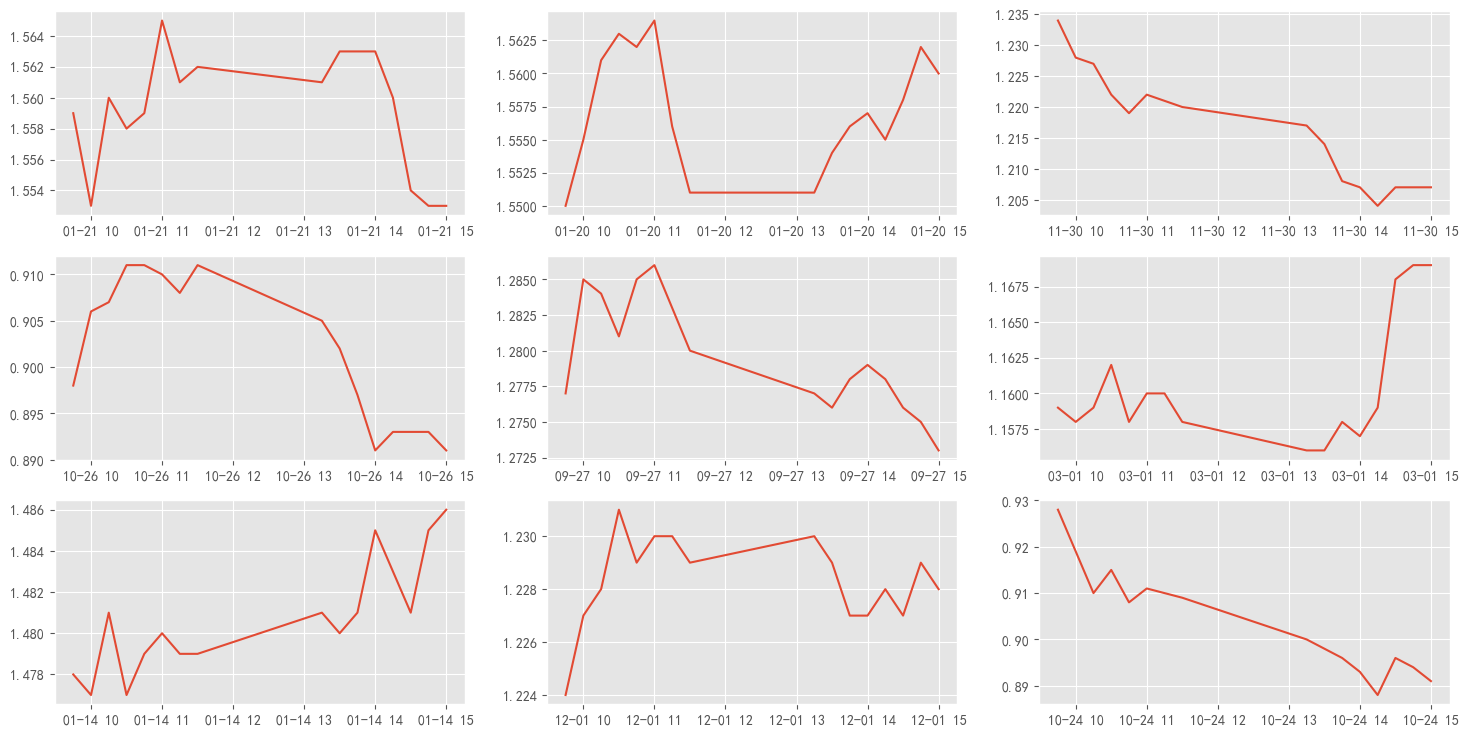

In [9]:
code = 159920

unit_df = pd.read_excel('./qdii/{}.xlsx'.format(code), header=3)
unit_df['unit_pct_change'] = unit_df['unit_floortrading'].pct_change()
unit_df['unit_pct_change_lag1'] = unit_df['unit_pct_change'].shift()
unit_df = unit_df[unit_df['unit_floortradingchange']!=unit_df['unit_floortrading']]

bar_df = pd.read_excel('./qdii/{}bar.xlsx'.format(code)).iloc[:-2]
bar_df['Date'] = bar_df['日期'].map(lambda x: datetime.datetime(x.year, x.month, x.day))
bar_df.rename(columns={'代码':'code', '名称':'name', '日期':'Timestamp', 
           '开盘价(元)':'open', '最高价(元)':'high', '最低价(元)':'low', '收盘价(元)':'close'}, inplace = True) 

unit_pct_change_head10 = unit_df.sort_values(by=['unit_pct_change_lag1'],ascending=False)['Date'].iloc[:9]
fig, ax = plt.subplots(3, 3, figsize=(18, 9))

i=0
for date in unit_pct_change_head10:
    bar_df_temp = bar_df[bar_df['Date'] == date].set_index('Timestamp')
    
    i += 1
    plt.subplot(int(str(33)+str(i)))
    plt.plot(bar_df_temp.index, bar_df_temp['close'])

# 2 Panel Regression

In [10]:
import os
from glob import glob
_ = os.path.dirname(os.path.abspath('whatever'))

bar_datapath_lst = []
unit_datapath_lst = []
for i in glob(os.path.join(_,'qdii','*')):
    if 'bar' in i:
        bar_datapath_lst.append(i)
    else:
        unit_datapath_lst.append(i)

bar_unit_panel_df = pd.DataFrame()
for path1 in tqdm_notebook(unit_datapath_lst):
    symbol = os.path.split(path1)[1][:6]
    unit_df = pd.read_excel(path1, header=3)
    unit_df['unit_pct_change_lag1'] = unit_df['unit_floortrading'].pct_change().shift()
    unit_df = unit_df[unit_df['unit_floortradingchange']!=unit_df['unit_floortrading']]
    for path2 in bar_datapath_lst:
        if symbol in path2:
            bar_df = pd.read_excel(path2).iloc[:-2]
            bar_df['Date'] = bar_df['日期'].map(lambda x: datetime.datetime(x.year, x.month, x.day))
            bar_df.rename(columns={'代码':'code', '名称':'name', '日期':'Timestamp', 
                       '开盘价(元)':'open', '最高价(元)':'high', '最低价(元)':'low', '收盘价(元)':'close'}, inplace = True) 
            bar_unit_df = pd.merge(bar_df, unit_df, on='Date', how='right')
    bar_unit_panel_df = pd.concat([bar_unit_panel_df, bar_unit_df], ignore_index=True)

bar_unit_panel_df = bar_unit_panel_df[bar_unit_panel_df['code'].notna()]

  0%|          | 0/15 [00:00<?, ?it/s]

In [11]:
start_end_lst = [
    [930, 1000],
    [1000, 1030],
    [1030, 1100],
    [1100, 1130],
    [930, 1130], # 上午
    
    [1300,1330],
    [1330,1400],
    [1400,1430],
    [1430,1500],
    [1300, 1500], # 下午
    
    [930, 1500], # 全天
]

In [12]:
def resample(df_grouped, start, end):
    df_grouped = df_grouped[(df_grouped['Timestamp'].map(lambda x:x.hour*100+x.minute)>=start) & 
                            (df_grouped['Timestamp'].map(lambda x:x.hour*100+x.minute)<=end)]
    if len(df_grouped):
        symbol_date_period_price = df_grouped['close']
        symbol_date_period_ret = symbol_date_period_price.iloc[-1]/symbol_date_period_price.iloc[0] - 1
        unit_pct_change_lag1 = df_grouped['unit_pct_change_lag1'].iloc[-1]
        return pd.DataFrame([symbol_date_period_ret, unit_pct_change_lag1]).T

In [13]:
for start, end in tqdm_notebook(start_end_lst):
    print('\nperiod:', int(np.floor(start/100)),':',str(start%100).rjust(2, '0'), '-', 
          int(np.floor(end/100)),':',str(end%100).rjust(2, '0'))
    bar_unit_panel_resample = bar_unit_panel_df.groupby(['code','Date']).apply(resample, start, end)
    bar_unit_panel_resample.columns = ['period_ret', 'unit_pct_change_lag1']
    bar_unit_panel_resample.reset_index(inplace=True)
    bar_unit_panel_resample.drop(['level_2'], axis=1, inplace=True)
    
    corr = np.corrcoef(bar_unit_panel_resample.dropna()['period_ret'], bar_unit_panel_resample.dropna()['unit_pct_change_lag1'])[0, 1]
    print("相关系数：", round(corr,4))

    # 定义面板数据（需要设置先个体后时间的层次化索引）/因变量/自变量
    panel_data = bar_unit_panel_resample.set_index(['code','Date'])
    dependent_variable = panel_data['period_ret']
    exogenous_variables = panel_data[['unit_pct_change_lag1']]

#     # 混合回归（不建议）
#     model = PanelOLS(dependent_variable, independent_variable, entity_effects=False, time_effects=False)  
#     model_result = model.fit()  
#     print(model_result.p_value)

#     # 个体固定效应
#     model = PanelOLS(dependent_variable, independent_variable, entity_effects=True, time_effects=False)  
#     model_result = model.fit()  
#     print(model_result)

#     # 时间固定效应
#     model = PanelOLS(dependent_variable, independent_variable, entity_effects=False, time_effects=True)  
#     model_result = model.fit()  
#     print(model_result)
    
    # 双向固定效应
    model = PanelOLS(dependent_variable, exogenous_variables, entity_effects=True, time_effects=True)  
    model_result = model.fit(cov_type='clustered', cluster_entity=True) 
    print(model_result.summary.tables[1])

  0%|          | 0/11 [00:00<?, ?it/s]


period: 9 : 30 - 10 : 00
相关系数： 0.0053
                                  Parameter Estimates                                   
                      Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
----------------------------------------------------------------------------------------
unit_pct_change_lag1     0.0007     0.0017     0.3999     0.6893     -0.0027      0.0041

period: 10 : 00 - 10 : 30
相关系数： 0.0559
                                  Parameter Estimates                                   
                      Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
----------------------------------------------------------------------------------------
unit_pct_change_lag1     0.0037     0.0020     1.8730     0.0611     -0.0002      0.0075

period: 10 : 30 - 11 : 00
相关系数： -0.0135
                                  Parameter Estimates                                   
                      Parameter  Std. Err.     T-stat    P-value    Lower CI   